In [1]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
data=pd.read_csv('inflation.csv', index_col='Date', parse_dates=True, dayfirst=True)
data.index=data.index.to_period(freq='Q') # converting the index to quarterly period instead of dates
data=data['01-1980':] # filtering the use data from Jan/1980 onwards
data.tail()

,Inflation
Date,
2016Q2,0.4
2016Q3,0.7
2016Q4,0.5
2017Q1,0.5
2017Q2,0.2


In [4]:
y=data['Inflation']

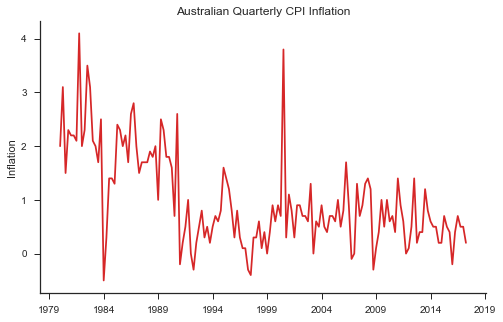

In [5]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([],minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

In [6]:
y.describe().round(2)

count    150.00
mean       1.00
std        0.88
min       -0.50
25%        0.40
50%        0.70
75%        1.58
max        4.10
Name: Inflation, dtype: float64

In [7]:
h = 4
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')
test

PeriodIndex(['2017Q3', '2017Q4', '2018Q1', '2018Q2'], dtype='period[Q-DEC]', freq='Q-DEC')

In [8]:
pred=pd.Series(np.repeat(y.iloc[-1], h), index=test)
pred

2017Q3    0.2
2017Q4    0.2
2018Q1    0.2
2018Q2    0.2
Freq: Q-DEC, dtype: float64

In [9]:
resid=y-y.shift(1)
sigma = resid.std()
round(sigma,3)

0.797

In [10]:
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2017Q3,-1.362,1.762
2017Q4,-2.009,2.409
2018Q1,-2.505,2.905
2018Q2,-2.924,3.324


In [11]:
import forecast # you need to download the forecast.py file from the Canvas

ses=forecast.ses(y)
ses.fit()
fitted=pd.Series(ses.smooth(), index=y.index)
ses.summary()

 Simple exponential smoothing

 Smoothing parameter:
 alpha  0.288 (0.072) 

 In-sample fit:
 MSE               0.424
 Log-likelihood   -148.486
 AIC               302.971
 BIC               312.003


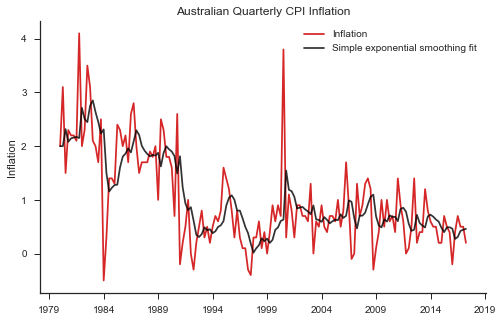

In [12]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red, label='Inflation')
fitted.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

In [13]:
resid=y-fitted

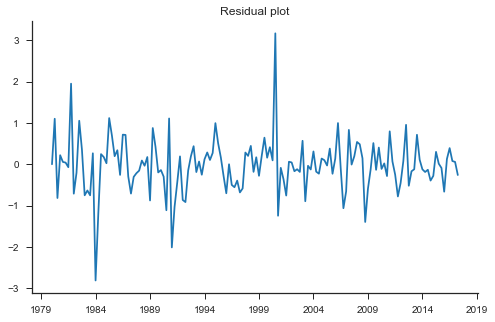

In [14]:
fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

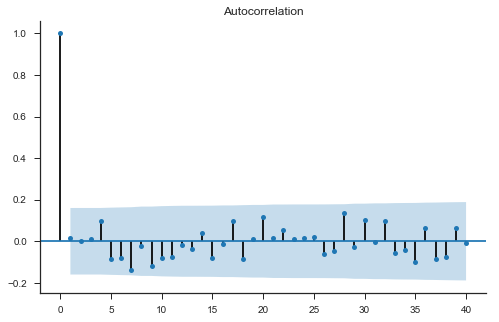

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

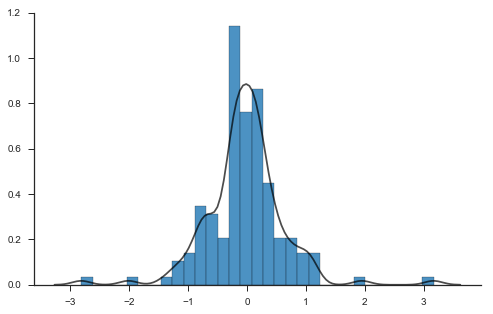

In [16]:
def hist(series):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid)
plt.show()

In [17]:
#y=y['1991':]
ses=forecast.ses(y)
ses.fit()
ses.summary()

 Simple exponential smoothing

 Smoothing parameter:
 alpha  0.288 (0.072) 

 In-sample fit:
 MSE               0.424
 Log-likelihood   -148.486
 AIC               302.971
 BIC               312.003


In [24]:
# Real time forecasting - use it as a template

validation=y['2004Q1':].index # the validation period is Q1 2004 onwards
start = y.index.get_loc('2004Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-1]) # random walk forecast
    
    model = forecast.ses(y.iloc[:i]) 
    model.fit()
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results = np.vstack([pred1,pred2,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

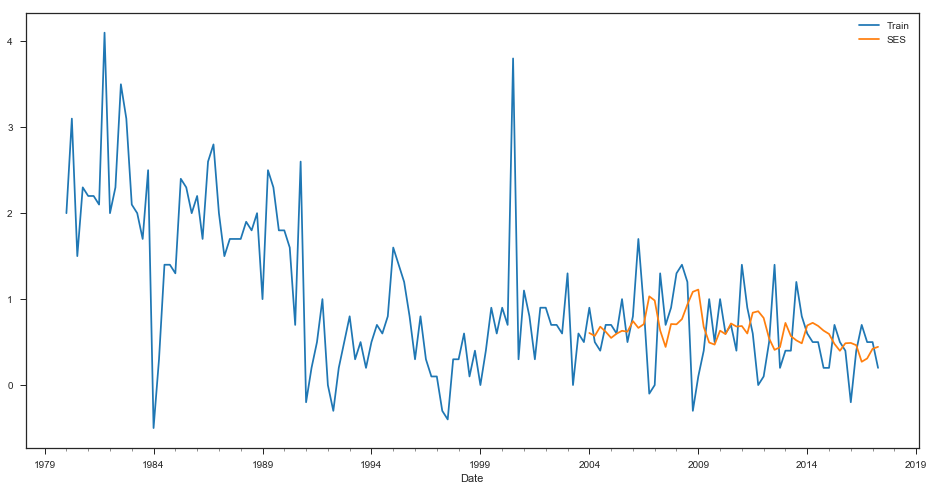

In [31]:
pred2 = pd.DataFrame(pred2, index = validation, columns=['Inflation'] )
plt.figure(figsize=(16,8))
data['Inflation'].plot(label='Train')
pred2['Inflation'].plot(label='SES')
plt.legend(loc='best')
plt.show()

In [29]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
RW,0.538,0.058
SES,0.499,0.055


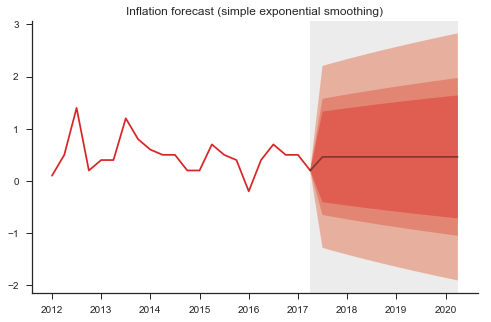

In [21]:
h=12

model = ses

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')

pred=pd.Series(model.forecast(h), index=test)

intv1=pd.DataFrame(model.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(model.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(model.intervalforecast(h, level=.99), index=test)

fig, ax = forecast.fanchart(y['01-2012':], pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.title('Inflation forecast (simple exponential smoothing)')

sns.despine()
plt.show()
